In [1]:
from pybaseball import schedule_and_record
from pybaseball import teamid_lookup
import pandas as pd
from pandasql import *
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import json

In [2]:
with open("team_data.json", "r") as read_file:
    team_data = json.load(read_file)
read_file.close()

color_palette = {}
for division in team_data:
    for team in team_data[division]:
        color_palette.update({team:team_data[division][team]['primary_color']})

In [7]:
def win_loss_num(x):
    if any(q in x for q in ['L','L-wo']):
        return 0
    else:
        return 1 

In [9]:
totaldf = pd.DataFrame()
for key in team_data:
    for team in team_data[key]:
        totaldf = totaldf.append(schedule_and_record(2021,team))
        totaldf.loc[totaldf['Tm'] == team,'Division'] = key
totaldf = totaldf[-totaldf['Time'].isna()]
totaldf['Wins'] = [int(x.split('-')[0]) for x in totaldf['W-L']]
totaldf['Losses'] = [int(x.split('-')[1]) for x in totaldf['W-L']]
totaldf['Won_Dummy'] = [win_loss_num(x) for x in totaldf['W/L']]
totaldf['Win_Perc'] = totaldf['Wins'] / (totaldf['Losses'] + totaldf['Wins'])
totaldf['Game_Number'] = totaldf['Wins'] + totaldf['Losses']

q = '''
select *
     , sum(case when home_away = 'Home' then 1 else 0 end) 
           over (partition by tm order by tm,game_number) home_games
     , sum(case when home_away = '@' then 1 else 0 end) 
           over (partition by tm order by tm,game_number) away_games
     , sum(case when home_away = 'Home' then won_dummy else 0 end) 
           over (partition by tm order by tm,game_number) home_wins
     , sum(case when home_away = '@' then won_dummy else 0 end) 
           over (partition by tm order by tm,game_number) away_wins
  from totaldf
order by tm, game_number
'''

totaldf = sqldf(q)

totaldf['Home_Win_Perc'] = totaldf['home_wins'] / totaldf['home_games']
totaldf['Away_Win_Perc'] = totaldf['away_wins'] / totaldf['away_games']

In [10]:
totaldf.head()

,Date,Tm,Home_Away,Opp,W/L,R,RA,Inn,W-L,Rank,...,Losses,Won_Dummy,Win_Perc,Game_Number,home_games,away_games,home_wins,away_wins,Home_Win_Perc,Away_Win_Perc
0,"Thursday, Apr 1",ARI,@,SDP,L,7.0,8.0,9.0,0-1,3.0,...,1,0,0.00,1,0,1,0,0,NaN,0.00
1,"Friday, Apr 2",ARI,@,SDP,L,2.0,4.0,9.0,0-2,5.0,...,2,0,0.00,2,0,2,0,0,NaN,0.00
2,"Saturday, Apr 3",ARI,@,SDP,L,0.0,7.0,9.0,0-3,5.0,...,3,0,0.00,3,0,3,0,0,NaN,0.00
3,"Sunday, Apr 4",ARI,@,SDP,W,3.0,1.0,9.0,1-3,4.0,...,3,1,0.25,4,0,4,0,1,NaN,0.25
4,"Tuesday, Apr 6",ARI,@,COL,W,10.0,8.0,13.0,2-3,3.0,...,3,1,0.40,5,0,5,0,2,NaN,0.40


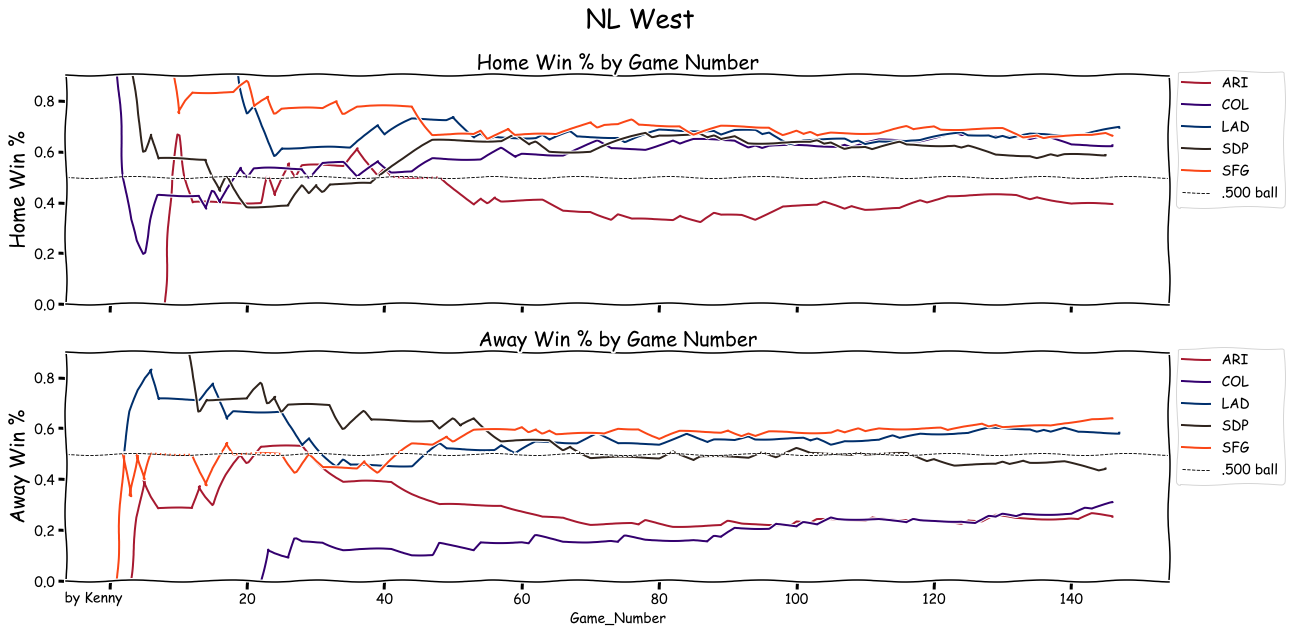

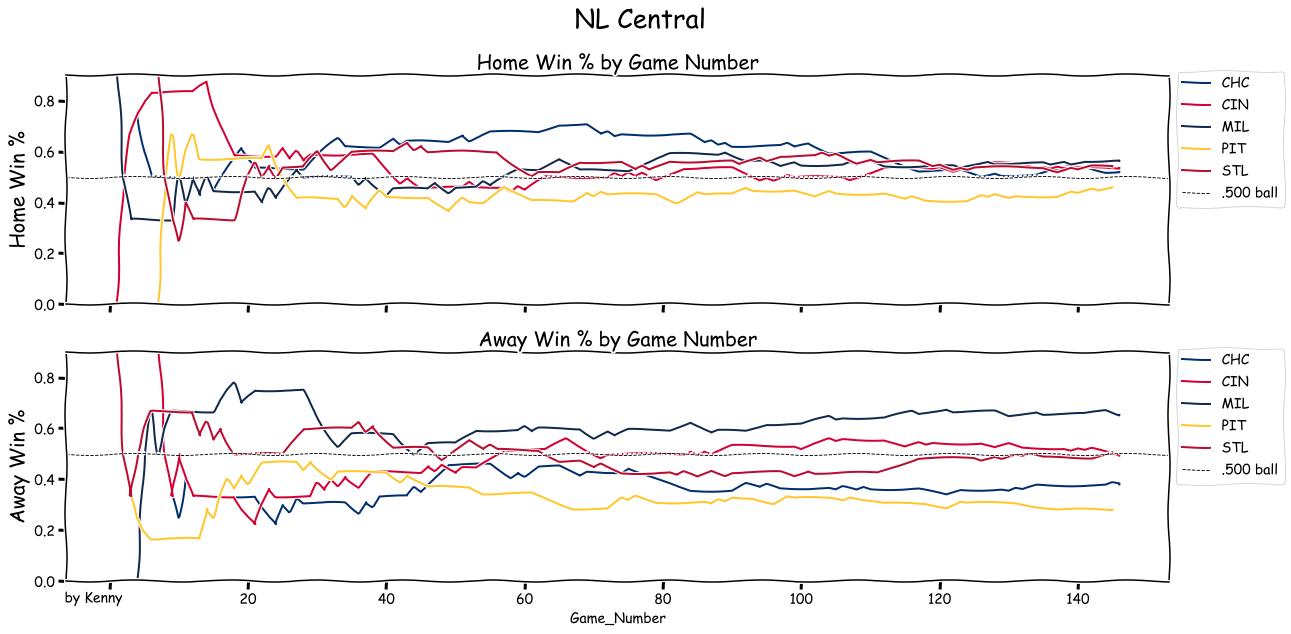

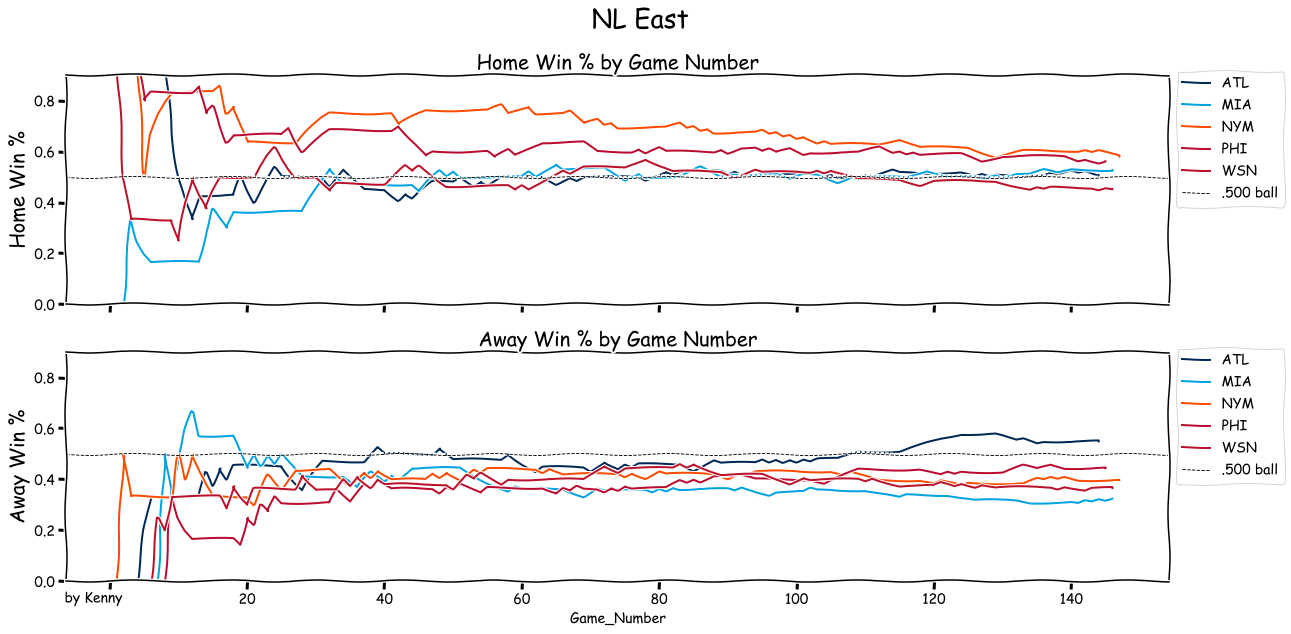

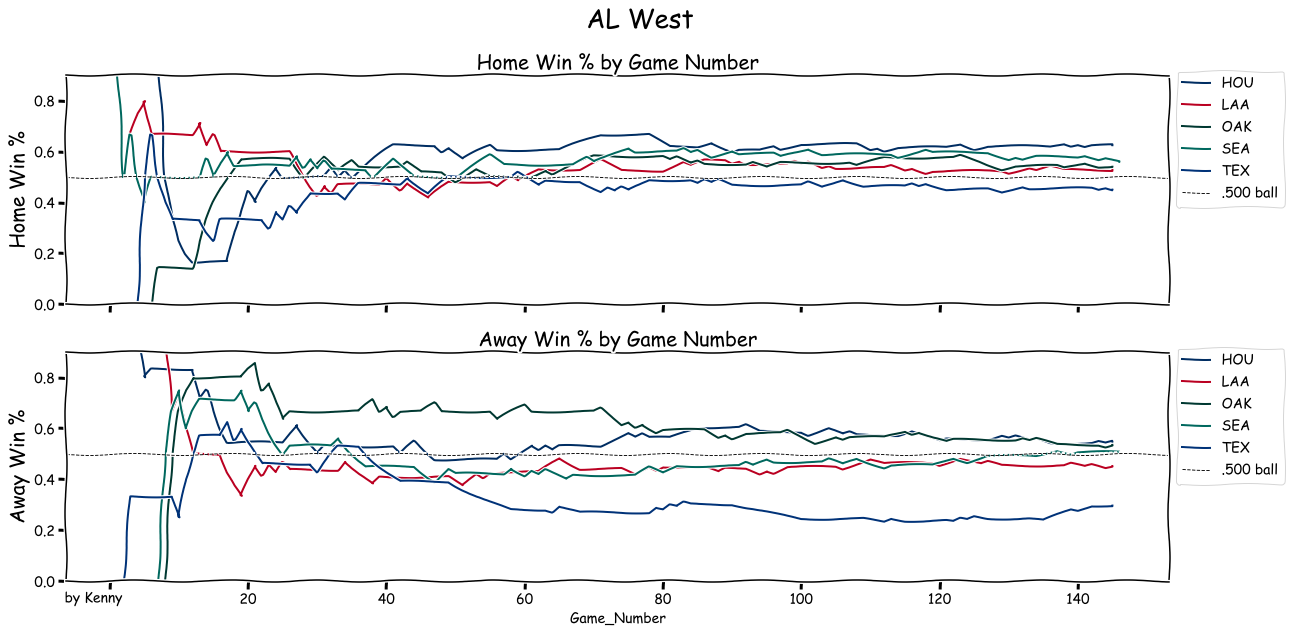

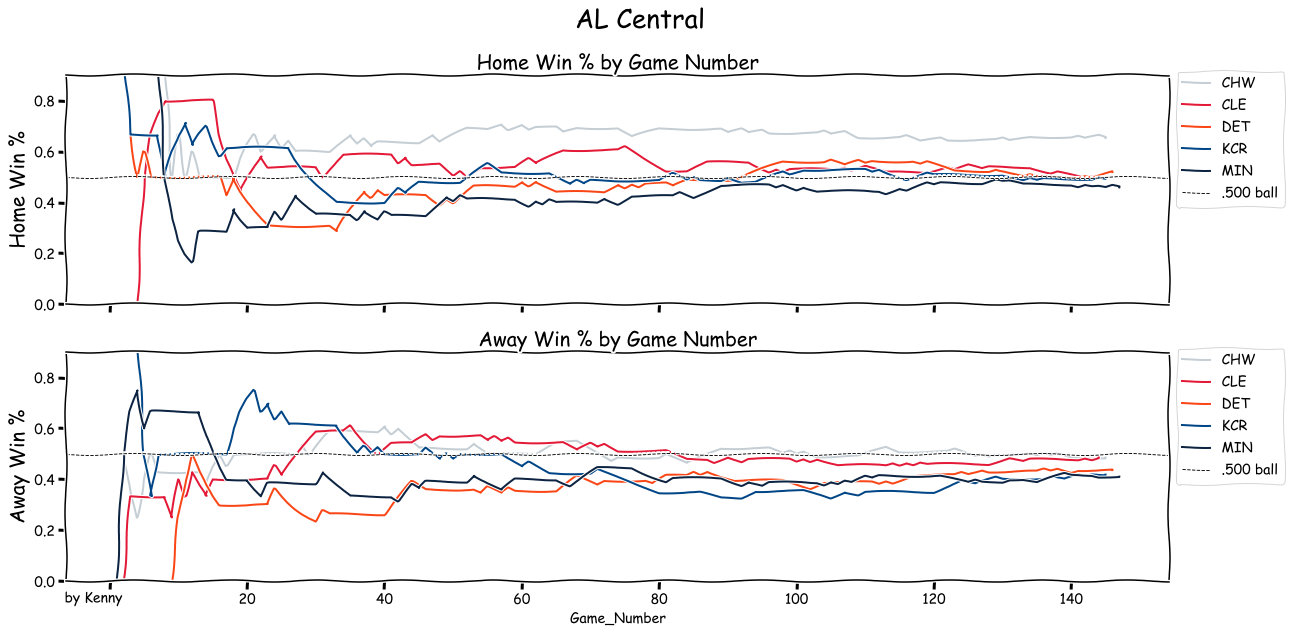

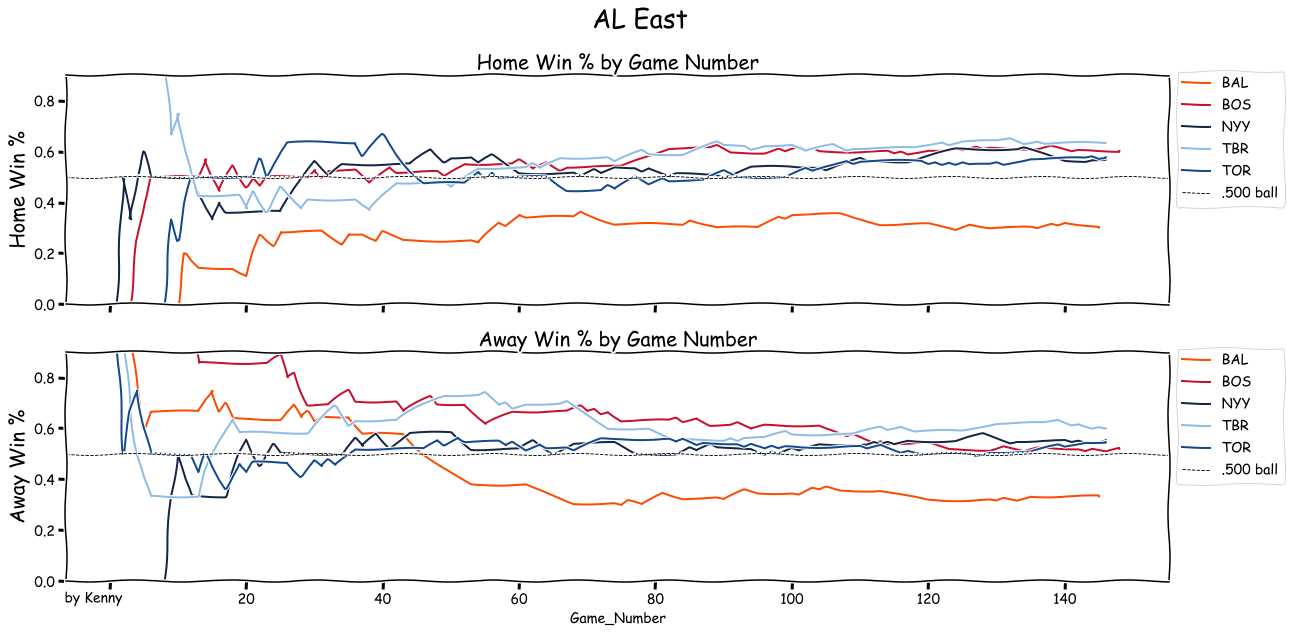

In [44]:
conf = dict(
    label_size=20,
    title_size=26,
    quad_text_size = 50,
    quad_text_alpha = .05
)
plt.xkcd()
for division in team_data:
    fig, axes = plt.subplots(2,1,figsize=(18,9),sharex=True)
    fig.suptitle(division
                 ,size=conf['title_size'])
    sns.lineplot(x='Game_Number',y='Home_Win_Perc'
                 ,data=totaldf[(totaldf['Division'] == division)]
                 ,ax=axes[0]
                 ,hue='Tm'
                 ,palette=color_palette)
    axes[0].set_title('Home Win % by Game Number'
                      ,size=conf['label_size'])
    axes[0].set_ylabel('Home Win %'
                      ,size=conf['label_size'])
    axes[0].axhline(.500,ls='--', c='k', lw=0.9, label=".500 ball")
    axes[0].set_ylim(0,.900)
    axes[0].legend(loc='upper right'
                   ,bbox_to_anchor=(1.11, 1.05)
                   ,fancybox = True)
    
    sns.lineplot(x='Game_Number',y='Away_Win_Perc'
                 ,data=totaldf[(totaldf['Division'] == division)]
                 ,ax=axes[1]
                 ,hue='Tm'
                 ,palette=color_palette)
    axes[1].set_title('Away Win % by Game Number'
                     ,size=conf['label_size'])
    axes[1].set_ylabel('Away Win %'
                      ,size=conf['label_size'])
    axes[1].axhline(.500,ls='--', c='k', lw=0.9, label=".500 ball")
    axes[1].set_ylim(0,.900)
    axes[1].legend(loc='upper right'
                   ,bbox_to_anchor=(1.11, 1.05)
                   ,fancybox = True)
    
    plt.tight_layout()
    plt.annotate("by Kenny", (.05,.05), xycoords='figure fraction')
    plt.savefig('%s.png' % division)
    plt.show()
